In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore-utils-nbs')
from utils import create_dataset, CharDataset, evaluate_loss, print_samples, get_lr_loss
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from sklearn.manifold import TSNE
import numpy as np
import torch

In [2]:
# Read file and create training and test sets
names, vocab, max_length = create_dataset('../names.txt')
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = CharDataset(names[:n1], vocab=vocab, max_length=max_length)
test_data = CharDataset(names[n1:], vocab=vocab, max_length=max_length)


In [3]:
class Head(nn.Module):
    def __init__(self, emb_dim, head_size, block_length):
        super(Head, self).__init__()
        self.key = nn.Linear(emb_dim, head_size, bias=False)
        self.query = nn.Linear(emb_dim, head_size, bias=False)
        self.value = nn.Linear(emb_dim, head_size, bias=False)
        # Define a register buffer
        self.register_buffer('tril', torch.tril(torch.ones(block_length,block_length)))

    def forward(self, x):
        B, T, C = x.shape
        ## Initialize the vector
        k = self.key(x) # B,T,head_size
        q = self.query(x) # B,T,head_size
        v = self.value(x) # B,T,head_size
        wei = k @ torch.transpose(q, 1, 2) * C**-0.5 # B,T,head_size * B,head_size,T -> B,T,T
        wei = torch.masked_fill(wei, self.tril[:T,:T] == 0, float('-Inf')) # Only selecting till the Tth column will be esp important during generation o/w will expect maxx_length columns at everytime step and throw an error
        wei = F.softmax(wei, dim=-1) # B,T,T
        # print(k.shape, q.shape, v.shape, wei.shape)
        out = wei @ v #B,T,T * B,T,H -> B,T,H i.e. 32,16,16 * 32,16,8 -> 32,16,8
        return out

In [4]:
class Xformer(nn.Module):
    def __init__(self, vocab_size, emb_dim, head_size, block_length):
        super(Xformer,self).__init__()
        self.token_embedding = nn.Embedding(vocab_size + 1, emb_dim)
        self.pos_embedding = nn.Embedding(vocab_size + 1, emb_dim)
        self.sa_head = Head(emb_dim, head_size, block_length)
        self.lm_head = nn.Linear(emb_dim, vocab_size)

    def forward(self, x, targets=None):
        tok_emb = self.token_embedding(x)
        pos_emb = self.pos_embedding(x)
        x = tok_emb + pos_emb # B, T, emb_dim
        x = self.sa_head(x) # B, T, head_size
        logits = self.lm_head(x) # B, T, vocab_size

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            # print(logits.view(-1, logits.size(-1)).shape, targets.view(-1).shape)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return(logits,loss)

In [5]:
# ## Hyperparameters
block_length = max_length + 1 
vocab_size = len(vocab) + 1
emb_dim = 8
head_size = 8

In [6]:
# Training loop 
batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [7]:
# # Test run on a batch size of 1 for debug
# model = Xformer(vocab_size, emb_dim, head_size, block_length)
# optimizer = Adam(model.parameters(), lr=0.01)
# criterion = nn.CrossEntropyLoss()
# xb, yb = next(iter(train_dataloader))
# # print(xb.shape, yb.shape)
# logits, loss = model(xb,yb)
# print(loss)

In [8]:
# Set up optimizer and model
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = Xformer(vocab_size, emb_dim, head_size, block_length)
optimizer = Adam(model.parameters(), lr=0.001)

In [9]:
xb, yb = next(iter(train_dataloader))
logits, loss = model(xb,yb)
print(loss)

tensor(3.4522, grad_fn=<NllLossBackward0>)


Text(0, 0.5, 'Loss')

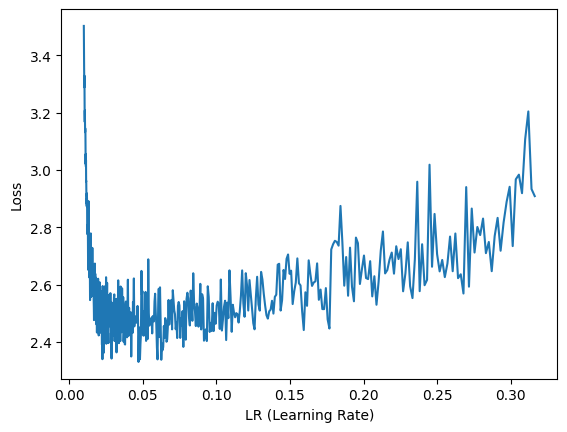

In [10]:
## Optimal lr sweep
import matplotlib.pyplot as plt
lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, batch_size, 500, -2, -0.5)
plt.plot(lri, lossi)
# Add labels to the x-axis and y-axis
plt.xlabel('LR (Learning Rate)')
plt.ylabel('Loss')

In [18]:
# Training loop - Initialized in separate loop so that it can be re run without reinitialization that will wipe things out
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []

In [38]:
# Training loop 
lr = 0.01
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10000
for steps in range(n_epochs):
    xb, yb = next(iter(train_dataloader))
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, test_dataloader, num_batches=10)
    tr_loss.append(tr_lossi)
    te_loss.append(te_lossi)
    # print(loss.item())

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())

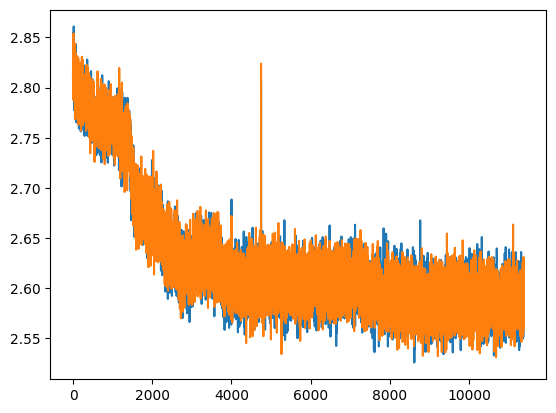

training loss:  2.5884
validation loss:  2.5905


In [ ]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss[10:])
plt.plot(te_loss[10:])

plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-100:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(te_loss[-100:]))).item(),4))

In [ ]:
## Pretty print the samples
print_samples(model, train_data, max_length, num=32)

elybyaddra
nne

lamasagh
cemerotan
evoleneh
lor
n
liyackallenesey
zelieynakyymofe

sh
ana
man
haessankynain
ea
ki
ylezsageaaas
y
okin
sk
tri
iacaaamezodeza
agahn
sotimeaaosaalaa


h
zayn
aen
sygalylatrlisos



['stop', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'blank']


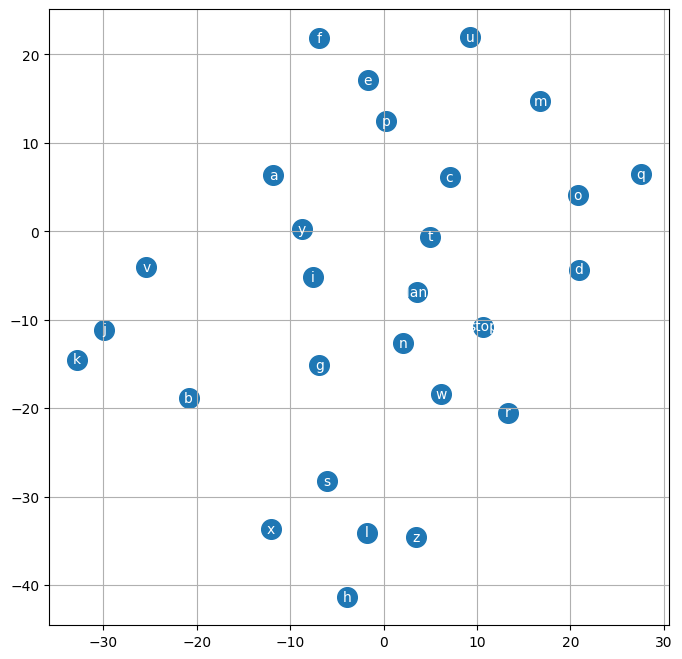

In [ ]:
## Plot tsne or pca for embeddings
# t-SNE example:
embeddings_matrix = model.token_embedding.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)

# Create vectors for ticklabels
ticklabels = list(train_data.itos.values())
ticklabels.insert(0,'stop')
ticklabels.insert(27,'blank')
x_ticklabel_vec = np.arange(len(ticklabels))
y_ticklabel_vec = np.arange(len(ticklabels))
print(ticklabels)

# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embeddings_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), ticklabels[i], ha="center", va="center", color='white')
plt.grid('minor')